In [7]:
import librosa
audio_file = 'Space_Large.wav'
y, sr = librosa.load(audio_file, sr=None)

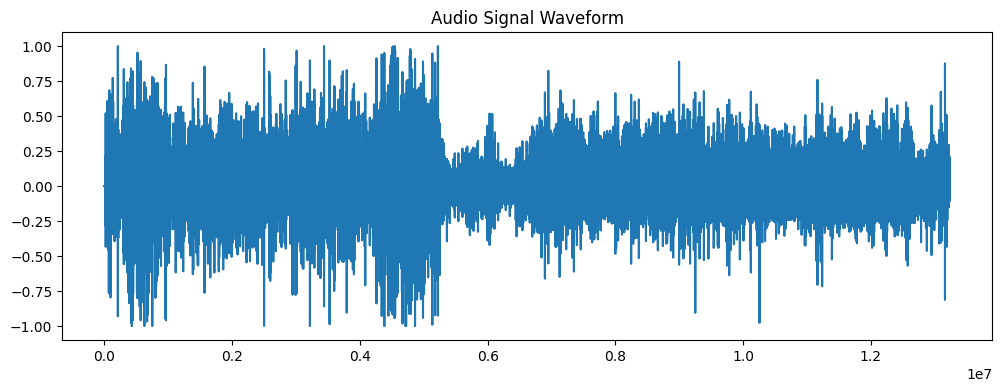

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Audio Signal Waveform')
plt.show()

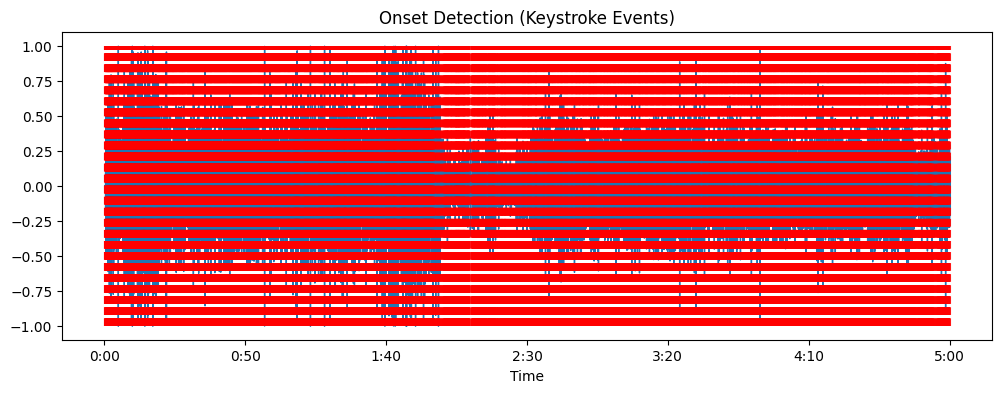

Onset Times (in seconds): [2.55419501e-01 3.71519274e-01 4.64399093e-01 ... 2.99792834e+02
 2.99874104e+02 3.00071474e+02]


In [9]:
import librosa.display
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times, -1, 1, color='r', alpha=0.9, linestyle='--', label='Onsets')
plt.title('Onset Detection (Keystroke Events)')
plt.show()
print("Onset Times (in seconds):", onset_times)

In [10]:
import numpy as np
from scipy.io.wavfile import write
output_dir = 'space/'
for i, onset_time in enumerate(onset_times):
    onset_sample = int(onset_time * sr)
    start_sample = max(0, onset_sample - int(0.05 * sr))
    end_sample = min(len(y), onset_sample + int(0.2 * sr))
    sample = y[start_sample:end_sample]
    sample_filename = f"{output_dir}sample_{i + 1}.wav"
    write(sample_filename, sr, np.array(sample * 32767, dtype=np.int16))
    print(f'Saved: {sample_filename}')

Saved: space/sample_1.wav
Saved: space/sample_2.wav
Saved: space/sample_3.wav
Saved: space/sample_4.wav
Saved: space/sample_5.wav
Saved: space/sample_6.wav
Saved: space/sample_7.wav
Saved: space/sample_8.wav
Saved: space/sample_9.wav
Saved: space/sample_10.wav
Saved: space/sample_11.wav
Saved: space/sample_12.wav
Saved: space/sample_13.wav
Saved: space/sample_14.wav
Saved: space/sample_15.wav
Saved: space/sample_16.wav
Saved: space/sample_17.wav
Saved: space/sample_18.wav
Saved: space/sample_19.wav
Saved: space/sample_20.wav
Saved: space/sample_21.wav
Saved: space/sample_22.wav
Saved: space/sample_23.wav
Saved: space/sample_24.wav
Saved: space/sample_25.wav
Saved: space/sample_26.wav
Saved: space/sample_27.wav
Saved: space/sample_28.wav
Saved: space/sample_29.wav
Saved: space/sample_30.wav
Saved: space/sample_31.wav
Saved: space/sample_32.wav
Saved: space/sample_33.wav
Saved: space/sample_34.wav
Saved: space/sample_35.wav
Saved: space/sample_36.wav
Saved: space/sample_37.wav
Saved: spa

In [ ]:
import os
import librosa
import numpy as np
spacebar_folder = 'space'
others_folder = 'others'
def load_audio_files(folder_path):
    audio_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            audio_files.append(file_path)
    return audio_files
spacebar_files = load_audio_files(spacebar_folder)
others_files = load_audio_files(others_folder)
print(f'Found {len(spacebar_files)} spacebar samples and {len(others_files)} other key samples')

Found 2585 spacebar samples and 2946 other key samples


In [12]:
import librosa
import numpy as np
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    y, _ = librosa.effects.trim(y)
    if len(y) == 0:
        print(f"Skipping {audio_path} due to empty audio")
        return None
    
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
        chroma = librosa.feature.chroma_stft(y=y, sr=sr) 
        zcr = librosa.feature.zero_crossing_rate(y)  
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr) 
        features = np.hstack([
            np.mean(mfccs, axis=1),   
            np.mean(chroma, axis=1),  
            np.mean(zcr),            
            np.mean(spectral_contrast, axis=1)
        ])
        
        return features
    
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        return None
X = []
y = []
for file in spacebar_files:
    features = extract_features(file)
    if features is not None:
        X.append(features)
        y.append(1)
for file in others_files:
    features = extract_features(file)
    if features is not None:
        X.append(features)
        y.append(0)

C:\Users\yonat\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

Accuracy: 0.985547


In [15]:
import joblib
joblib.dump(clf, 'key_prediction_model_large.joblib')

['key_prediction_model_large.joblib']

In [ ]:
import numpy as np
import sounddevice as sd
import librosa
import time
from sklearn.ensemble import RandomForestClassifier
def extract_features(audio_data, sr):
    y, _ = librosa.effects.trim(audio_data)

    if len(y) == 0:
        print("Audio is empty after trimming.")
        return None
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(zcr),
        np.mean(spectral_contrast, axis=1)
    ])
    
    return features
def record_audio(duration=2):
    print("Recording...")
    fs = 22050  # Sample rate
    audio_data = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64')
    sd.wait()
    print("Recording finished.")
    return audio_data.flatten(), fs
try:
    while True:
        recorded_audio, sample_rate = record_audio(duration=2)
        features = extract_features(recorded_audio, sample_rate)
        if features is not None:
            features = features.reshape(1, -1)
            probabilities = clf.predict_proba(features)[0]
            print(f"Probabilities: Spacebar: {probabilities[1]:.2f}, Other Key: {probabilities[0]:.2f}")
            threshold = 0.8
            prediction = 1 if probabilities[1] >= threshold else 0
            label = "Spacebar" if prediction == 1 else "Other Key"
            print(f"Prediction: {label}")
        
        time.sleep(1)

except KeyboardInterrupt:
    print("Exiting the testing loop.")

In [1]:
import numpy as np
import librosa
import sounddevice as sd
import joblib
import time
from sklearn.ensemble import RandomForestClassifier
def extract_features(audio_data, sr):
    y, _ = librosa.effects.trim(audio_data)
    if len(y) == 0:
        print("Audio is empty after trimming.")
        return None
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(zcr),
        np.mean(spectral_contrast, axis=1)
    ])
    
    return features
def record_audio(duration=2):
    print("Recording...")
    fs = 22050
    audio_data = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64')
    sd.wait()
    print("Recording finished.")
    return audio_data.flatten(), fs
clf_loaded = joblib.load('key_prediction_model.joblib')
print("Model loaded.")
try:
    while True:
        recorded_audio, sample_rate = record_audio(duration=2)
        features = extract_features(recorded_audio, sample_rate)
        if features is not None:
            features = features.reshape(1, -1)
            probabilities = clf_loaded.predict_proba(features)[0]
            print(f"Probabilities: Spacebar: {probabilities[1]:.2f}, Other Key: {probabilities[0]:.2f}")
            threshold = 0.8
            prediction = 1 if probabilities[1] >= threshold else 0
            label = "Spacebar" if prediction == 1 else "Other Key"
            print(f"Prediction: {label}")
        time.sleep(1) 

except KeyboardInterrupt:
    print("Exiting the testing loop.")

Model loaded.
Recording...
Exiting the testing loop.
